In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

**Data Loading and understanding**

In [30]:
# load csv file into dataframe
df = pd.read_csv('/content/Churn_Modelling.csv')

In [31]:
df.shape

(10000, 14)

In [32]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
pd.set_option('display.max_columns', None)

In [34]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [35]:
# Drop unnecessary columns
df.drop(["RowNumber","CustomerId","Surname"], axis=1, inplace=True)

In [36]:
# Target column
target = "Exited"
X = df.drop(target, axis=1)
y = df[target]

**3. Train/Test Split**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

**4. Preprocessing**

In [38]:
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [39]:
# Transform data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

**5. Handle Class Imbalance (SMOTE)**

In [40]:
print("Before SMOTE:", np.bincount(y_train))
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_trans, y_train)
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [6370 1630]
After SMOTE: [6370 6370]


**6. Random Forest - Hyperparameter Tuning**

In [44]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [6, 8, 10, 12, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
}

rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, scoring="f1", cv=3, verbose=1, random_state=42, n_jobs=-1)
rf_search.fit(X_train_res, y_train_res)

best_rf = rf_search.best_estimator_
print("\nBest RandomForest Parameters:", rf_search.best_params_)

rf_probs = best_rf.predict_proba(X_test_trans)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best RandomForest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}


**7. XGBoost - Hyperparameter Tuning**

In [48]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

xgb_params = {
    "n_estimators": [300, 400, 500],
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, scoring="f1", cv=3, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_res, y_train_res)

best_xgb = xgb_search.best_estimator_
print("\nBest XGB Parameters:", xgb_search.best_params_)

xgb_probs = best_xgb.predict_proba(X_test_trans)[:,1]

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best XGB Parameters: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


**8. Model Evaluation Function**

In [49]:
def evaluate_model(name, probs, y_true):
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.argmax(f1)
    best_thr = thresholds[max(0,best_idx-1)]
    y_pred = (probs >= best_thr).astype(int)

    print(f"\n==== {name} Model Evaluation ====")
    print("Best Threshold:", round(best_thr,4))
    print("Best F1 Score:", round(f1[best_idx],4))
    print("Precision:", round(precision[best_idx],4))
    print("Recall:", round(recall[best_idx],4))
    print("Average Precision Score (AUC-PR):", average_precision_score(y_true, probs))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    return precision, recall, f1

prec_rf, rec_rf, f1_rf = evaluate_model("Random Forest", rf_probs, y_test)
prec_xgb, rec_xgb, f1_xgb = evaluate_model("XGBoost", xgb_probs, y_test)


==== Random Forest Model Evaluation ====
Best Threshold: 0.48
Best F1 Score: 0.6152
Precision: 0.6237
Recall: 0.6069
Average Precision Score (AUC-PR): 0.6461483909159084
Confusion Matrix:
 [[1443  150]
 [ 160  247]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.62      0.61      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000


==== XGBoost Model Evaluation ====
Best Threshold: 0.5102
Best F1 Score: 0.6289
Precision: 0.6771
Recall: 0.5872
Average Precision Score (AUC-PR): 0.7094594565895295
Confusion Matrix:
 [[1478  115]
 [ 168  239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1593
           1       0.68      0.59      0.63       407

    accuracy                   

**9. Precision-Recall Curve**

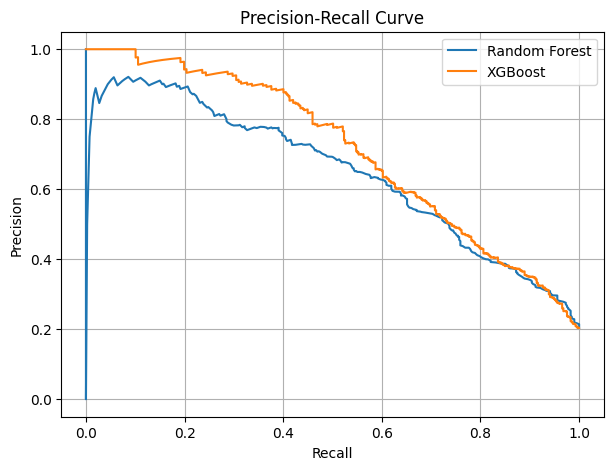

In [51]:
plt.figure(figsize=(7,5))
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

 **10. Feature Importances (XGBoost)**

In [53]:
importances = best_xgb.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Features:\n", feat_imp.head(10))


Top 10 Features:
                    Feature  Importance
4       num__NumOfProducts    0.172685
12        cat__Gender_Male    0.158845
6      num__IsActiveMember    0.136655
1                 num__Age    0.111068
9   cat__Geography_Germany    0.106283
11      cat__Gender_Female    0.071467
2              num__Tenure    0.067345
10    cat__Geography_Spain    0.055411
8    cat__Geography_France    0.046383
3             num__Balance    0.036793
